# Full Moon Theatre Planning

This notebook is designed to help planning Full Moon Theatre events.

We start by importing the required external Python libraries.

In [97]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylunar
import geopy
from geopy.geocoders import Nominatim
from datetime import datetime
import math

We then select a location, the starting and ending dates for the Full Moon Theatre workshop and the target moment for the performance event.

The location should be indicated with the syntax "Location name, Country Code", for instance "Montpellier, FR".

In [98]:
# LOCATION_NAME = "Montpellier, FR"
LOCATION_NAME = "Hooke Park, UK"
TARGET_MOMENT = (2023, 3, 7, 23, 0, 0) # format: (YEAR, MONTH, DAY, HOUR, MINUTES, SECONDS)
START_DAY = [2023, 3, 4] # format: [YEAR, MONTH, DAY]
END_DAY = [2023, 3, 8] # format: [YEAR, MONTH, DAY]

We use the Nominatim service to derive the latitude and longitude of the selected location.

In [99]:
geolocator = Nominatim(user_agent="full_moon")
location = geolocator.geocode(LOCATION_NAME)
print("Address:", location.address)
print("Latitude:", location.latitude)
print("Longitude:", location.longitude)

Address: Hooke Park, Hooke, North Poorton, Dorset, England, United Kingdom
Latitude: 50.790707850000004
Longitude: -2.6816552948061627


We then define the following function to help converting decimal degrees to degrees, minutes and seconds. 
We must do this because the `pylunar` library uses this input format for latitude and longitude.

In [100]:
def deg_to_dms(deg):
    """Convert from decimal degrees to degrees, minutes, seconds."""
    m, s = divmod(abs(deg)*3600, 60)
    d, m = divmod(m, 60)
    if deg < 0:
        d = -d
    d, m = int(d), int(m)
    return d, m, s

In [101]:
latitude_dms = deg_to_dms(location.latitude)
longitude_dms = deg_to_dms(location.longitude)
print("Latitude (DMS):", latitude_dms)
print("Longitude (DMS):", longitude_dms)

Latitude (DMS): (50, 47, 26.548260000010487)
Longitude (DMS): (-2, 40, 53.959061302186456)


We can now use the `pylunar` library to obtain information about the Moon position and conditions on the target date and time.

In [102]:
moon_info = pylunar.MoonInfo(latitude_dms, longitude_dms)
moon_info.update(TARGET_MOMENT)
print("Target Moon's azimuth:", moon_info.azimuth())
print("Target Moon's altitude:", moon_info.altitude())
print("Target Moon's age (days):", moon_info.age())
print("Target Moon's fractional phase:", moon_info.fractional_phase())
print("Target Moon's phase name:", moon_info.phase_name())
print("Target Moon's magnitude (measure of the brightness of a celestial object):", moon_info.magnitude())
print("Distance of target Moon's from Earth:", moon_info.earth_distance(), "km")
print("Next four Moon phases:", moon_info.next_four_phases())

Target Moon's azimuth: 144.65941779039477
Target Moon's altitude: 39.84749437258364
Target Moon's age (days): 15.66264150380448
Target Moon's fractional phase: 0.997227474278652
Target Moon's phase name: WANING_GIBBOUS
Target Moon's magnitude (measure of the brightness of a celestial object): -12.55
Distance of target Moon's from Earth: 395191.1220988026 km
Next four Moon phases: [('last_quarter', (2023, 3, 15, 2, 8, 14.773621)), ('new_moon', (2023, 3, 21, 17, 23, 5.702937)), ('first_quarter', (2023, 3, 29, 2, 32, 19.954955)), ('full_moon', (2023, 4, 6, 4, 34, 28.605438))]


Now we calculate the position of the Moon over the workshop days for every hour.

In [122]:
# moon_positions = []
moon_positions = pd.DataFrame(columns = ["year","month","day","hour","azimuth","altitude"])
for year in range(START_DAY[0], END_DAY[0]+1):
    for month in range(START_DAY[1], END_DAY[1]+1):
        for day in range(START_DAY[2], END_DAY[2]+1):
            for hour in range(0,24):
                moment = (year, month, day, hour, 0, 0)
                moon_info.update(moment)
                if moon_info.altitude()>0:
                    moon_positions.loc[len(moon_positions)] = [year, month, day, hour, 
                                                               moon_info.azimuth(), 90-moon_info.altitude()]
print(moon_positions)

      year  month  day  hour     azimuth   altitude
0   2023.0    3.0  4.0   0.0  233.300520  36.230743
1   2023.0    3.0  4.0   1.0  249.720349  44.487957
2   2023.0    3.0  4.0   2.0  262.821745  53.571244
3   2023.0    3.0  4.0   3.0  274.149477  62.890494
4   2023.0    3.0  4.0   4.0  284.683897  72.062661
..     ...    ...  ...   ...         ...        ...
65  2023.0    3.0  8.0   7.0  273.188552  87.412629
66  2023.0    3.0  8.0  20.0   96.883235  83.372826
67  2023.0    3.0  8.0  21.0  108.787264  74.630305
68  2023.0    3.0  8.0  22.0  121.710788  66.477937
69  2023.0    3.0  8.0  23.0  136.228328  59.482920

[70 rows x 6 columns]


And finally we plot these positions in a polar diagram.

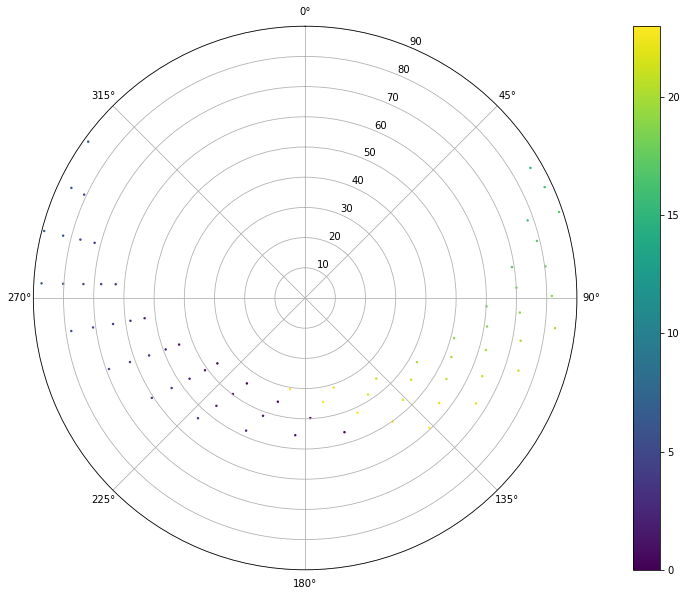

In [129]:
# moon_positions['azimuth_rad'] = moon_positions.apply(lambda row: row.azimuth*math.pi/180, axis=1)
# plt.polar(moon_positions['azimuth_rad'].values,moon_positions['altitude'].values)
# plt.show()

ax = plt.subplot(1, 1, 1, projection='polar')

points = ax.scatter(np.radians(moon_positions['azimuth'].values), moon_positions['altitude'].values,
                    s=2, label=None, c=moon_positions['hour'].values)
ax.figure.colorbar(points)
# ax.figure.legend(loc='upper left')
ax.set_theta_zero_location('N', offset=0)
# ax.set_theta_zero_location('S', offset=0)
ax.set_theta_direction(-1)
ax.set_rmax(90)

plt.rcParams['figure.figsize'] = [10, 5]
plt.show()
